
Based on ddpg_training.py

This script is used to visualize the inference from a DDPG model trained via PPO for pose prediction using purely visual inputs. 


In [ ]:
import os
import time
import rclpy
from random_motion_logger import RandomMotionLogger
from dead_reckoning import FinalPoseProcessor
import torch

# Import PPO inference function here
from infer_utils import (
    infer_poses,
    load_actor,
    load_feature_extractor,
    NUM_FRAMES,
    HISTORY_LENGTH,
)


NUM_FRAMES = 32
IMAGE_DIR = '/home/earl/workspaces/rldr/infer_trajectory'

def collect_random_trajectory(node):
    """
    Moves the robot randomly and collects 32 images.
    Returns a list of image file paths.
    """
    node.start_new_trajectory()
    while node.frame_count < NUM_FRAMES:
        rclpy.spin_once(node, timeout_sec=0.1)
    
    # Collect the image paths
    image_paths = [os.path.join(node.traj_path, f"frame_{i:04d}.jpg") for i in range(NUM_FRAMES)]
    return image_paths


rclpy.init()
# 1. Start random motion and collect images
random_motion_node = RandomMotionLogger()


Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
xFormers not available
xFormers not available
INFO:dinov2:using MLP layer as FFN


Exception in thread [INFO] [1748372518.900657189] [random_motion_logger]: Waiting for ENTER key to start a new trajectory...
Thread-5 (keypress_listener):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/earl/workspaces/turtlevision/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/earl/workspaces/rldr/random_motion_logger.py", line 118, in keypress_listener
    old_settings = termios.tcgetattr(fd)
termios.error: (25, 'Inappropriate ioctl for device')


nvbufsurftransform: Could not get EGL display connection


In [3]:
# Inference batch over all trajectories

import os
import torch
import pandas as pd
from infer_utils import infer_poses, load_actor, load_feature_extractor, NUM_FRAMES, HISTORY_LENGTH

# Configuration
TRAJ_ROOT      = '/home/earl/workspaces/rldr/trajectories'
CHECKPOINT_PATH= '/home/earl/workspaces/rldr/infer_trajectory/best_ddpg_2.pt'

# 1. Load model & feature extractor once
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
actor  = load_actor(CHECKPOINT_PATH, device, history_length=HISTORY_LENGTH)
feat_ex= load_feature_extractor(device)

# 2. Iterate over each traj folder, run inference, collect final poses
records = []
for traj in sorted(os.listdir(TRAJ_ROOT)):
    traj_path = os.path.join(TRAJ_ROOT, traj)
    if not os.path.isdir(traj_path):
        continue

    # collect up to NUM_FRAMES images
    image_paths = [
        os.path.join(traj_path, fname)
        for fname in sorted(os.listdir(traj_path))
        if fname.endswith('.jpg')
    ][:NUM_FRAMES]
    if len(image_paths) < NUM_FRAMES:
        print(f"Skipping {traj}: only {len(image_paths)} images")
        continue

    # run inference
    poses = infer_poses(image_paths, actor, feat_ex, device, history_length=HISTORY_LENGTH)
    pred_x, pred_y, pred_theta = poses[-1]

    records.append({
        "traj_id": traj,
        "x_pred":  pred_x,
        "y_pred":  pred_y,
        "theta_pred": pred_theta
    })
    print(f"{traj}: x={pred_x:.3f}, y={pred_y:.3f}, θ={pred_theta:.1f}°")

# 3. Build DataFrame of all final‐pose predictions
df_preds = pd.DataFrame(records)
df_preds

traj_000: x=0.748, y=0.746, θ=104.2°
traj_001: x=0.748, y=0.745, θ=104.6°
traj_002: x=0.747, y=0.742, θ=93.2°
traj_003: x=0.741, y=0.733, θ=84.7°
traj_004: x=0.737, y=0.725, θ=79.4°
traj_005: x=0.744, y=0.736, θ=84.8°
traj_006: x=0.728, y=0.715, θ=69.8°
traj_007: x=0.742, y=0.735, θ=87.1°
traj_008: x=0.742, y=0.735, θ=84.3°
traj_009: x=0.736, y=0.727, θ=73.9°
traj_010: x=0.744, y=0.739, θ=89.5°
traj_011: x=0.744, y=0.738, θ=87.6°
traj_012: x=0.746, y=0.742, θ=92.1°
traj_013: x=0.746, y=0.741, θ=92.6°
traj_014: x=0.747, y=0.743, θ=94.9°
traj_015: x=0.747, y=0.744, θ=97.1°
traj_016: x=0.746, y=0.741, θ=85.9°
traj_017: x=0.745, y=0.740, θ=88.1°
traj_018: x=0.748, y=0.745, θ=101.4°
traj_019: x=0.745, y=0.740, θ=87.5°
traj_020: x=0.739, y=0.728, θ=77.7°
traj_021: x=0.746, y=0.740, θ=88.7°
traj_022: x=0.747, y=0.745, θ=102.0°
traj_023: x=0.743, y=0.736, θ=87.9°
traj_024: x=0.745, y=0.740, θ=86.8°
traj_025: x=0.740, y=0.731, θ=81.7°
traj_026: x=0.747, y=0.744, θ=101.0°
traj_027: x=0.746, y=0.

,traj_id,x_pred,y_pred,theta_pred
0,traj_000,0.748313,0.746069,104.153534
1,traj_001,0.748106,0.745254,104.606602
2,traj_002,0.746688,0.742184,93.232952
3,traj_003,0.741286,0.732703,84.739496
4,traj_004,0.736945,0.725359,79.413541
...,...,...,...,...
1275,traj_995,0.745785,0.740514,83.258032
1276,traj_996,0.736673,0.724661,79.034400
1277,traj_997,0.746706,0.742657,96.244987
1278,traj_998,0.745296,0.740063,88.196273


In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# === Config ===
GRID_SIZE = 5
CELL_SIZE = 0.3 # m
NUM_ORIENT = 72
LAMBDA_POS = 1.0
LAMBDA_ORI = 2.0

def action_to_pose(action_id):
    ang = action_id % NUM_ORIENT
    idx = action_id // NUM_ORIENT
    row, col = divmod(idx, GRID_SIZE)
    x = (col - GRID_SIZE // 2) * CELL_SIZE
    y = (row - GRID_SIZE // 2) * CELL_SIZE
    theta = ang * (360.0 / NUM_ORIENT)
    return [x, y, theta]

def pose_error(pred, gt, λ_pos=LAMBDA_POS, λ_ori=LAMBDA_ORI):
    dx, dy = pred[0] - gt[0], pred[1] - gt[1]
    pos_err = (dx**2 + dy**2)**0.5
    ori_err = abs((pred[2] - gt[2] + 180) % 360 - 180)
    return λ_pos * pos_err**2 + λ_ori * (ori_err / 180.0)**2

def analyze_logs(root_dir):
    records = []
    # grid covers [−(GRID_SIZE*CELL_SIZE)/2, +(GRID_SIZE*CELL_SIZE)/2]
    offset = (GRID_SIZE * CELL_SIZE) / 2.0

    for traj_folder in sorted(os.listdir(root_dir)):
        traj_path = os.path.join(root_dir, traj_folder)
        log_path  = os.path.join(traj_path, "log.csv")
        if not os.path.isfile(log_path):
            continue

        try:
            df = pd.read_csv(log_path)
            for _, row in df.iterrows():
                if 'action_id' not in row or pd.isna(row['action_id']):
                    continue

                action_id = int(row["action_id"])
                gt_x  = float(row["rel_x"])
                gt_y  = float(row["rel_y"])
                gt_th = float(row["rel_theta"])

                # compute pose error
                pred_pose = action_to_pose(action_id)
                err = pose_error(pred_pose, [gt_x, gt_y, gt_th])

                # convert ground‐truth (x,y) into 5×5 cell bins
                x_bin = int(np.floor((gt_x + offset) / CELL_SIZE))
                y_bin = int(np.floor((gt_y + offset) / CELL_SIZE))
                x_bin = min(max(x_bin, 0), GRID_SIZE-1)
                y_bin = min(max(y_bin, 0), GRID_SIZE-1)

                theta_bin = action_id % NUM_ORIENT

                records.append({
                    "x_bin":      x_bin,
                    "y_bin":      y_bin,
                    "theta_bin":  theta_bin,
                    "pose_error": err
                })
        except Exception as e:
            print(f"[WARN] Skipped {traj_path}: {e}")

    return pd.DataFrame(records)

def plot_pose_error_maps(df):
    # Heatmap of average pose error per (x, y)
    plt.figure(figsize=(6, 5))
    heatmap = df.groupby(["y_bin", "x_bin"])["pose_error"].mean().unstack()
    sns.heatmap(heatmap, annot=True, fmt=".3f", cmap="Reds")
    plt.title("Average Pose Error per (x, y) Bin")
    plt.xlabel("x_bin")
    plt.ylabel("y_bin")
    plt.tight_layout()
    plt.show()

    # Barplot of average pose error per theta_bin
    plt.figure(figsize=(10, 4))
    theta_avg = df.groupby("theta_bin")["pose_error"].mean()
    sns.barplot(x=theta_avg.index, y=theta_avg.values, color="salmon")
    plt.title("Average Pose Error per Orientation Bin")
    plt.xlabel("theta_bin")
    plt.ylabel("Avg Pose Error")
    plt.tight_layout()
    plt.show()

def plot_cell_orientation_histograms(df):
    """
    Plot a 5×5 grid of cells where:
      - x (row index) is vertical ↑ (north),
      - y (col index) is horizontal → (east).
    Each cell shows a histogram of orientation angles in [-180,180],
    and the bottom row displays x-ticks.
    Cell background color encodes sample count.
    """
    # compute counts per cell
    counts_xy = (
        df.groupby(['x_bin','y_bin'])
          .size()
          .unstack(fill_value=0)
          .reindex(index=range(GRID_SIZE),
                   columns=range(GRID_SIZE),
                   fill_value=0)
    )

    # collect raw 0→360° angles per cell
    angles_xy = {
        (x, y): (
            df.loc[(df.x_bin==x)&(df.y_bin==y), 'theta_bin']
              * (360.0/NUM_ORIENT)
        ).values
        for x in range(GRID_SIZE)
        for y in range(GRID_SIZE)
    }

    # prepare colormap
    vmax = counts_xy.values.max()
    norm = mcolors.Normalize(vmin=0, vmax=vmax)
    cmap = plt.cm.Reds

    # square figure + constrained layout for roughly square subplots
    fig, axes = plt.subplots(
        GRID_SIZE, GRID_SIZE,
        figsize=(10,10),
        subplot_kw={'projection':'polar'},
        constrained_layout=True
    )

    # build 13 bins around the circle
    num_bins  = 26
    bin_edges = np.linspace(0, 2*np.pi, num_bins+1)

    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            ax = axes[GRID_SIZE-1-x, y]
            thetas = np.deg2rad(angles_xy[(x, y)])
            ax.hist(thetas, bins=bin_edges, color='k', alpha=0.7)
            ax.set_yticks([])
            ax.set_theta_zero_location('N')   # zero at top
            ax.set_theta_direction(-1)        # clockwise
            ax.set_facecolor(cmap(norm(counts_xy.at[x,y])))

    # Overlay a grid on the array of rose plots
    for i in range(GRID_SIZE+1):
        # Horizontal lines
        fig.add_artist(plt.Line2D(
            [0, 1], [i / GRID_SIZE, i / GRID_SIZE],
            color='gray', linewidth=1, alpha=0.7, transform=fig.transFigure, zorder=100
        ))
        # Vertical lines
        fig.add_artist(plt.Line2D(
            [i / GRID_SIZE, i / GRID_SIZE], [0, 1],
            color='gray', linewidth=1, alpha=0.7, transform=fig.transFigure, zorder=100
        ))

    # Adjust layout to make space for suptitle and colorbar
    plt.subplots_adjust(top=1.90, bottom=0.10)

    # main title
    plt.suptitle('Orientation Distributions (0° at top center)',y=1.02)

    # colorbar in the newly freed space at the very bottom
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar_ax = fig.add_axes([0.15, -0.07, 0.7, 0.025])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    cbar.set_label('Sample Count')

    plt.show()

/tmp/ipykernel_5360/2926275648.py:166: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=1.90, bottom=0.10)


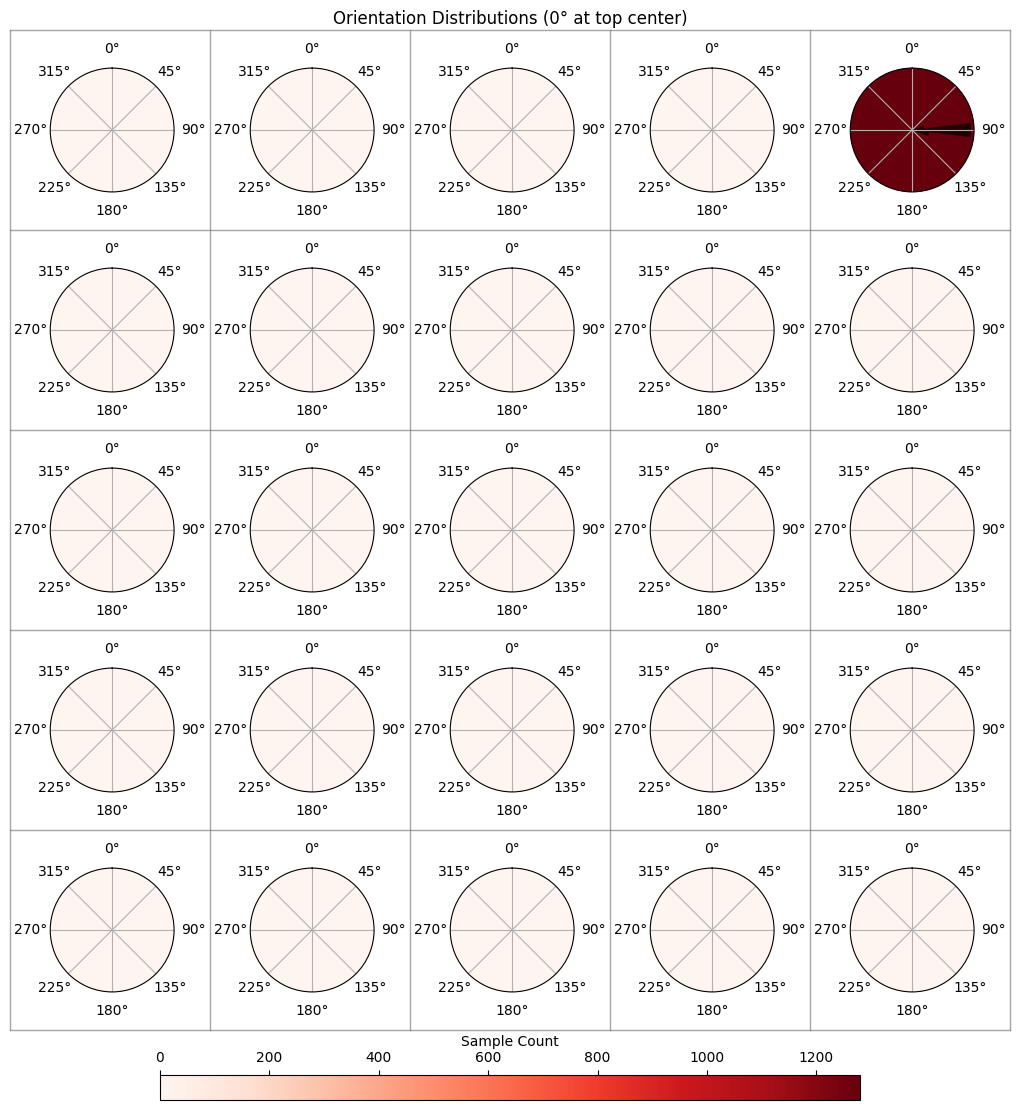

In [10]:
# Prepare df_preds for plot_cell_orientation_histograms

import numpy as np

# === reuse CONFIG from above cells ===
GRID_SIZE   = 5
CELL_SIZE   = 0.3     # m
NUM_ORIENT  = 72

# center‐offset to convert from [−half, +half] coords → bin index
offset   = (GRID_SIZE * CELL_SIZE) / 2.0
bin_size = 360.0 / NUM_ORIENT

# assume df_preds has columns ['traj_id','x_pred','y_pred','theta_pred']
# 1) compute x_bin, y_bin
df_preds['x_bin'] = (
    np.floor((df_preds['x_pred'] + offset) / CELL_SIZE)
    .clip(0, GRID_SIZE - 1)
    .astype(int)
)
df_preds['y_bin'] = (
    np.floor((df_preds['y_pred'] + offset) / CELL_SIZE)
    .clip(0, GRID_SIZE - 1)
    .astype(int)
)

# 2) compute theta_bin
df_preds['theta_bin'] = (
    (df_preds['theta_pred'] / bin_size)
    .round()
    .astype(int)
    % NUM_ORIENT
)

# 3) we don’t need pose_error here – plot_cell_orientation_histograms only uses x_bin,y_bin,theta_bin

# 4) call the plotting function
plot_cell_orientation_histograms(df_preds)

In [6]:
for x in range(GRID_SIZE):
    for y in range(GRID_SIZE):
        print(f"Cell ({x},{y}):", angles_xy[(x, y)])

NameError: name 'angles_xy' is not defined